In [1]:
!pip install koolbox scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import json
import glob

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"
    
    original_path = "/kaggle/input/calories-burnt-prediction/calories.csv"

    metric = root_mean_squared_error
    target = "Calories"
    n_folds = 5
    seed = 42

    cv = KFold(n_splits=n_folds, random_state=seed, shuffle=True)

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [5]:
original = pd.read_csv(CFG.original_path, index_col="User_ID")
original["Gender"] = original["Gender"].map({"male": 0, "female": 1})
original = original.rename(columns={"Gender": "Sex"})

X_original = original.drop(CFG.target, axis=1)
y_original = np.log1p(original[CFG.target])

In [6]:
mutual_info = mutual_info_regression(X, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.640567
Body_Temp,1.120766
Heart_Rate,0.976966
Age,0.098387
Height,0.056501
Weight,0.055709
Sex,0.017174


In [7]:
mutual_info = mutual_info_regression(X_original, y_original, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_original.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.494968
Body_Temp,0.986528
Heart_Rate,0.866243
Age,0.035208
Weight,0.020520
Sex,0.016184
Height,0.005213


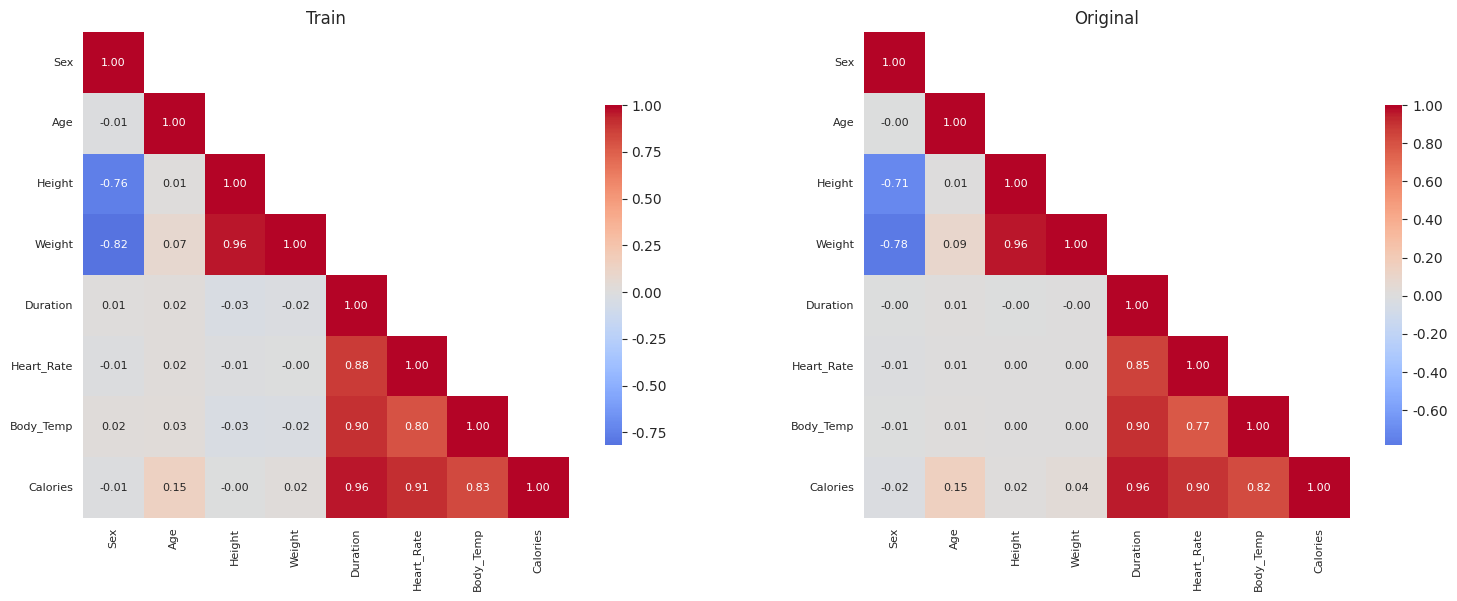

In [8]:
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[0]
)
axes[0].set_title('Train')
axes[0].tick_params(axis='both', which='major', labelsize=8)

corr_orig = original.corr()
mask_orig = np.triu(np.ones_like(corr_orig, dtype=bool), k=1)
sns.heatmap(
    data=corr_orig,
    annot=True,
    fmt='.2f',
    mask=mask_orig,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[1]
)
axes[1].set_title('Original')
axes[1].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Training base models

In [9]:
histgb_params = {
    "l2_regularization": 10.412017522533768,
    "learning_rate": 0.011702680619474444,
    "max_depth": 59,
    "max_features": 0.30616140080552673,
    "max_iter": 4454,
    "max_leaf_nodes": 385,
    "min_samples_leaf": 50,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.8213924491907012,
    "learning_rate": 0.059976685297931195,
    "min_child_samples": 10,
    "min_child_weight": 0.5425237767880097,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 89,
    "random_state": 42,
    "reg_alpha": 2.0325709613371545,
    "reg_lambda": 87.27971117911044,
    "subsample": 0.6452823633939004,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.9068724002629094,
    "learning_rate": 0.06459027654473874,
    "min_child_samples": 39,
    "min_child_weight": 0.5337673729810578,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 13,
    "random_state": 42,
    "reg_alpha": 1.603969498256519,
    "reg_lambda": 10.806488455621444,
    "subsample": 0.5966412222358356,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.8606487417581108,
    "colsample_bynode": 0.9410596660335436,
    "colsample_bytree": 0.9407540036296737,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 0.023260595738991977,
    "learning_rate": 0.03669372905801298,
    "max_depth": 11,
    "max_leaves": 51,
    "min_child_weight": 96,
    "n_estimators": 50000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 2.953205886504917,
    "reg_lambda": 67.64147033446291,
    "subsample": 0.6973241930754311,
    "verbosity": 0
}

cb_params = {
    "border_count": 88,
    "colsample_bylevel": 0.7903437608890396,
    "depth": 8,
    "eval_metric": "RMSE",
    "iterations": 50000,
    "l2_leaf_reg": 6.065104074215131,
    "learning_rate": 0.030946464122148992,
    "min_child_samples": 138,
    "random_state": 42,
    "random_strength": 0.035251008593976785,
    "verbose": False
}

In [10]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [11]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y, extra_X=X_original, extra_y=y_original)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_error: 0.0594 - Time: 74.61 s
--- Fold 1 - root_mean_squared_error: 0.0605 - Time: 71.33 s
--- Fold 2 - root_mean_squared_error: 0.0597 - Time: 73.69 s
--- Fold 3 - root_mean_squared_error: 0.0601 - Time: 64.90 s
--- Fold 4 - root_mean_squared_error: 0.0593 - Time: 69.42 s

------ Overall root_mean_squared_error: 0.0598 - Mean root_mean_squared_error: 0.0598 ± 0.0004 - Time: 354.73 s


## LightGBM (gbdt)

In [12]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[791]	valid_0's rmse: 0.0596226	valid_0's l2: 0.00355485
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 24.46 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0603528	valid_0's l2: 0.00364246
Early stopping, best iteration is:
[1369]	valid_0's rmse: 0.0603066	valid_0's l2: 0.00363688
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 37.66 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0596239	valid_0's l2: 0.00355501
Early stopping, best iteration is:
[1406]	valid_0's rmse: 0.0595985	valid_0's l2: 0.00355198
--- Fold 2 - root_mean_squared_error: 0.0596 - Time: 38.04 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0601725	valid_0's l2: 0.00362073
[2000]	valid_0's rmse: 0.060028	valid_0's l2: 0.00360336
Early stopping, best iteration is

## LightGBM (goss)

In [13]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0600588	valid_0's l2: 0.00360706
[2000]	valid_0's rmse: 0.0597145	valid_0's l2: 0.00356582
[3000]	valid_0's rmse: 0.0596177	valid_0's l2: 0.00355427
Early stopping, best iteration is:
[3424]	valid_0's rmse: 0.0595945	valid_0's l2: 0.0035515
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 92.69 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0607929	valid_0's l2: 0.00369577
[2000]	valid_0's rmse: 0.0604315	valid_0's l2: 0.00365197
[3000]	valid_0's rmse: 0.0603068	valid_0's l2: 0.00363691
Early stopping, best iteration is:
[3299]	valid_0's rmse: 0.0602872	valid_0's l2: 0.00363454
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 87.09 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0600734	valid_0's l2: 0.00360881
[2000]	valid_0's rmse: 0.0597328	valid_0's l2: 0.00356801
[3000]	valid_0's 

## XGBoost

In [14]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000
}

xgb_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:0.92856
[1000]	validation_0-rmse:0.06015
[2000]	validation_0-rmse:0.06009
[3000]	validation_0-rmse:0.06007
[3122]	validation_0-rmse:0.06006
--- Fold 0 - root_mean_squared_error: 0.0601 - Time: 71.52 s

[0]	validation_0-rmse:0.93096
[1000]	validation_0-rmse:0.06137
[2000]	validation_0-rmse:0.06128
[3000]	validation_0-rmse:0.06123
[3071]	validation_0-rmse:0.06123
--- Fold 1 - root_mean_squared_error: 0.0612 - Time: 77.12 s

[0]	validation_0-rmse:0.92964
[1000]	validation_0-rmse:0.06065
[2000]	validation_0-rmse:0.06056
[3000]	validation_0-rmse:0.06053
[3092]	validation_0-rmse:0.06053
--- Fold 2 - root_mean_squared_error: 0.0605 - Time: 78.56 s

[0]	validation_0-rmse:0.92813
[1000]	validation_0-rmse:0.06097
[1243]	validation_0-rmse:0.06096
--- Fold 3 - root_mean_squared_error: 0.0610 - Time: 36.78 s

[0]	validation_0-rmse:0.92887
[1000]	validation_0-rmse:0.06014
[2000]	validation_0-rmse:0.06007
[2596]	validation_0-rmse:0.06005
--- Fold 4 - root_

## CatBoost

In [15]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args=fit_args, extra_X=X_original, extra_y=y_original)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 0.9348709	test: 0.9341488	best: 0.9341488 (0)	total: 121ms	remaining: 1h 40m 58s
1000:	learn: 0.0571087	test: 0.0593244	best: 0.0593244 (1000)	total: 50s	remaining: 40m 47s
2000:	learn: 0.0560120	test: 0.0591679	best: 0.0591679 (2000)	total: 1m 38s	remaining: 39m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05911377754
bestIteration = 2824

Shrink model to first 2825 iterations.
--- Fold 0 - root_mean_squared_error: 0.0591 - Time: 144.74 s

0:	learn: 0.9342850	test: 0.9365766	best: 0.9365766 (0)	total: 72.3ms	remaining: 1h 15s
1000:	learn: 0.0571036	test: 0.0598252	best: 0.0598252 (1000)	total: 50s	remaining: 40m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05966835269
bestIteration = 1741

Shrink model to first 1742 iterations.
--- Fold 1 - root_mean_squared_error: 0.0597 - Time: 92.74 s

0:	learn: 0.9346164	test: 0.9352198	best: 0.9352198 (0)	total: 62ms	remaining: 51m 42s
1000:	learn: 0.057

## AutoGluon

In [16]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e05-calorie-expenditure-prediction-automl/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e05-calorie-expenditure-prediction-automl/*_test_preds_*.pkl')

ag_oof_preds = np.log1p(joblib.load(oof_preds_files[0]))
ag_test_preds = np.log1p(joblib.load(test_preds_files[0]))

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

# Ensembling with Ridge

In [17]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [18]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [19]:
joblib.dump(X, "oof_preds.pkl")
joblib.dump(X_test, "test_preds.pkl")

['test_preds.pkl']

In [20]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=CFG.cv,
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-04 21:17:17,012] A new study created in memory with name: no-name-fd861408-bf00-4988-abac-7ac496bf5129
[I 2025-05-04 21:17:20,976] Trial 2 finished with value: 0.05898702166925062 and parameters: {'alpha': 3.251886193246454, 'tol': 0.006071232569131528}. Best is trial 2 with value: 0.05898702166925062.
[I 2025-05-04 21:17:20,984] Trial 0 finished with value: 0.05898888434341537 and parameters: {'alpha': 6.415899043350888, 'tol': 0.008862101224573123}. Best is trial 2 with value: 0.05898702166925062.
[I 2025-05-04 21:17:21,315] Trial 1 finished with value: 0.05898917081240923 and parameters: {'alpha': 6.7826958212121236, 'tol': 0.0023423396289169664}. Best is trial 2 with value: 0.05898702166925062.
[I 2025-05-04 21:17:21,320] Trial 3 finished with value: 0.0589869414735883 and parameters: {'alpha': 3.0036321182352177, 'tol': 0.004292203411468358}. Best is trial 3 with value: 0.0589869414735883.
[I 2025-05-04 21:17:25,431] Trial 7 finished with value: 0.05898880064966242 and 

In [21]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 1.8912865010023905,
  "tol": 0.0029820687995857588
}


In [22]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = np.expm1(ridge_trainer.predict(X_test))

Training Ridge

--- Fold 0 - root_mean_squared_error: 0.0589 - Time: 0.14 s
--- Fold 1 - root_mean_squared_error: 0.0595 - Time: 0.11 s
--- Fold 2 - root_mean_squared_error: 0.0589 - Time: 0.11 s
--- Fold 3 - root_mean_squared_error: 0.0592 - Time: 0.11 s
--- Fold 4 - root_mean_squared_error: 0.0585 - Time: 0.11 s

------ Overall root_mean_squared_error: 0.0590 - Mean root_mean_squared_error: 0.0590 ± 0.0003 - Time: 1.40 s


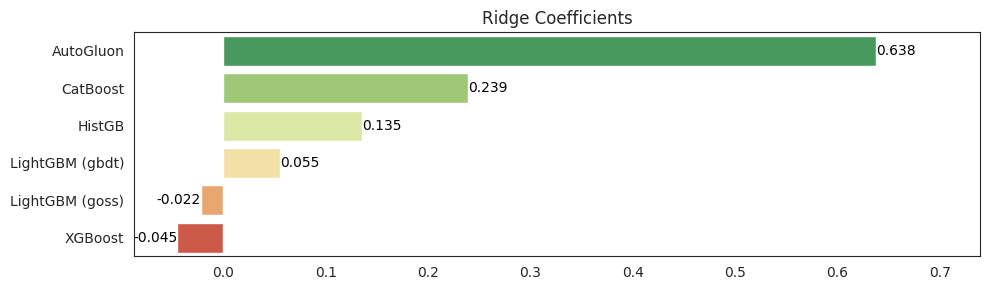

In [23]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [24]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.209919
1,750001,107.740871
2,750002,87.144622
3,750003,125.802554
4,750004,76.020595


# Results

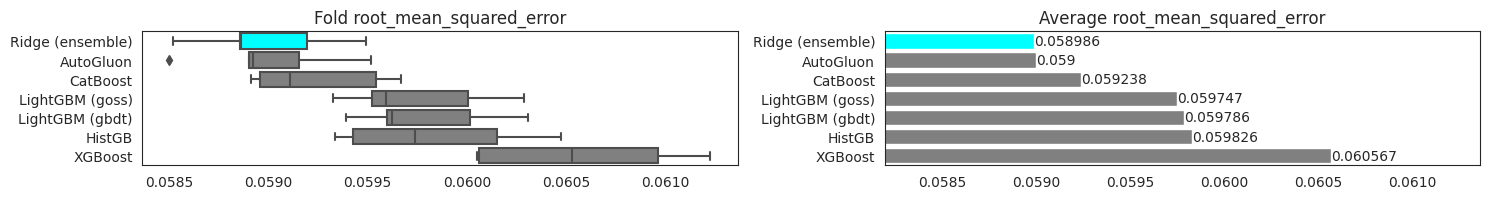

In [25]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [26]:
shutil.rmtree("catboost_info", ignore_errors=True)